# Imports and Dataset Downloads

In [107]:
import os
import torch
print("Using torch", torch.__version__)

Using torch 2.1.1


In [2]:
from torch_geometric.datasets import NELL, WikiCS, Wikidata5M

In [3]:
import torch_geometric

In [4]:
from torch_geometric import nn
import torch_geometric.transforms as T

In [349]:
transform = T.Compose([
    T.RandomLinkSplit(num_val=0.05,  # ratio of edges including in the validation set
                      num_test=0.2,  # ratio of edges including in the test set
                      is_undirected=True,
                      add_negative_train_samples=False),
])

In [351]:
wiki5m_dataset = Wikidata5M("/Users/rohan/Documents/483FinalProject/tmp/wiki5m", transform=transform)

In [352]:
wiki5m_train, wiki5m_val, wiki5m_test = wiki5m_dataset[0]

In [353]:
print("Wiki5m:")
print("\tNumber of the nodes in training, validation and test data are", wiki5m_train.num_nodes, wiki5m_val.num_nodes, wiki5m_test.num_nodes)
print("\tNumber of the edges in training, validation and test data are", wiki5m_train.num_edges, wiki5m_val.num_edges, wiki5m_test.num_edges)
print("\tNumber of the edge_label_index in training, validation and test data are", wiki5m_train.edge_label_index.shape[1],
                                                                                  wiki5m_val.edge_label_index.shape[1],
                                                                                  wiki5m_test.edge_label_index.shape[1])

Wiki5m:
	Number of the nodes in training, validation and test data are 4815483 4815483 4815483
	Number of the edges in training, validation and test data are 15686280 15686280 16732032
	Number of the edge_label_index in training, validation and test data are 7843140 1045752 4183008
WikiCS:
	Number of the nodes in training, validation and test data are 11701 11701 11701
	Number of the edges in training, validation and test data are 324186 324186 345798
	Number of the edge_label_index in training, validation and test data are 162093 21612 86448


# Model Creation and Training

In [363]:
import torch
import torch.nn as nn

class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(TransE, self).__init__()
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)

        nn.init.xavier_uniform_(self.entity_embeddings.weight.data)
        nn.init.xavier_uniform_(self.relation_embeddings.weight.data)

    def forward(self, edge_index, edge_type):
        head_emb = self.entity_embeddings(edge_index[0])
        tail_emb = self.entity_embeddings(edge_index[1])
        relation_emb = self.relation_embeddings(edge_type
        score = torch.norm(head_emb + relation_emb - tail_emb, p=1, dim=1)
        return score

In [133]:
from torch_geometric.utils import structured_negative_sampling

In [378]:
def train(model, data, optimizer, criterion):
    model.train()
    total_loss = 0
    # for data in data_loader:
    batch_mask = torch.rand(len(data.edge_index[0]))<0.2
    edge_index = torch.stack((data.edge_index[0][batch_mask], data.edge_index[1][batch_mask]))
    edge_type = data.edge_type[batch_mask]
        
    optimizer.zero_grad()
    temp = structured_negative_sampling(
          edge_index=edge_index,  # positive edges in the graph
          num_nodes=data.x.shape[0],  # number of nodes
        )# 4
    negative_edges = torch.stack((temp[0], temp[2]))
    
    # pos_labels = torch.ones(data.train_edge_index[0].size(0), dtype=torch.float)
    # labels = torch.cat((pos_labels, pos_labels-1))
    
    # edge_index, edge_type = torch.cat((data.train_edge_index, negative_edges), 1), torch.cat((data.train_edge_type, data.train_edge_type))
    # predictions = model(edge_index, edge_type)
    pos_scores = model(edge_index, edge_type)
    neg_scores = model(negative_edges, edge_type)
    
    loss = criterion(pos_scores, neg_scores, torch.ones_like(pos_scores))
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    return total_loss

@torch.no_grad()
def mrr_score(model, data):
    model.eval()
    total_mrr = 0

    batch_mask = torch.rand(len(data.edge_index[0]))<0.02
    edge_index = torch.stack((data.edge_index[0][batch_mask], data.edge_index[1][batch_mask]))
    edge_type = data.edge_type[batch_mask]
    count = len(edge_type)

    # edge_index, edge_type = data.edge_index, data.edge_type
    scores = []
    num_relations = torch.max(data.edge_type)
    for i in range(num_relations):
        test_edge_type = (torch.zeros(len(edge_type))+i).type(torch.int)
        scores.append(model(edge_index, test_edge_type))
    scores = torch.stack(scores)
    _, indices = torch.sort(scores, descending=True, dim=0)
    rank_sums = torch.sum(edge_type == indices, axis=1) / torch.arange(1, num_relations+1, dtype=torch.float)
    total_mrr = torch.sum(rank_sums)
    return total_mrr / count

In [379]:
num_entities = wiki5m_train.x.shape[0]  # Total number of unique entities
num_relations = torch.max(wiki5m_train.edge_type)+1  # Total number of unique relations
embedding_dim = 50  # Size of embedding vectors

model = TransE(num_entities, num_relations, embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MarginRankingLoss(margin=1.0)

In [382]:
num_epochs = 200
losses = []
mrrs = []
for epoch in range(num_epochs):
    loss = train(model, wiki5m_train, optimizer, criterion)
    losses.append(loss)
    valid_mrr = mrr_score(model, wiki5m_test)
    mrrs.append(valid_mrr)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss}, Val: {valid_mrr}')

Epoch 1/200, Loss: 0.911604642868042, Val: 0.029715947806835175
Epoch 2/200, Loss: 0.8930143117904663, Val: 0.03437596186995506
Epoch 3/200, Loss: 0.8750548958778381, Val: 0.041410692036151886
Epoch 4/200, Loss: 0.8575268387794495, Val: 0.05260855332016945
Epoch 5/200, Loss: 0.8384714126586914, Val: 0.0711439847946167
Epoch 6/200, Loss: 0.8200156092643738, Val: 0.09395091980695724
Epoch 7/200, Loss: 0.8005425333976746, Val: 0.11972364038228989
Epoch 8/200, Loss: 0.7820600271224976, Val: 0.14334696531295776
Epoch 9/200, Loss: 0.7634016275405884, Val: 0.169088676571846
Epoch 10/200, Loss: 0.745299220085144, Val: 0.21487180888652802
Epoch 11/200, Loss: 0.7263205051422119, Val: 0.2506497800350189
Epoch 12/200, Loss: 0.7060300707817078, Val: 0.27533307671546936
Epoch 13/200, Loss: 0.6870982050895691, Val: 0.2916596829891205
Epoch 14/200, Loss: 0.6684723496437073, Val: 0.3023907244205475
Epoch 15/200, Loss: 0.6510396003723145, Val: 0.31110888719558716
Epoch 16/200, Loss: 0.6336842775344849, 

In [397]:
import matplotlib.pyplot as plt
def plot_curves(curves):
    epochs = range(1, len(curves["train"]) + 1)

    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, curves["train"], label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [404]:
max(mrrs)

tensor(0.3772)

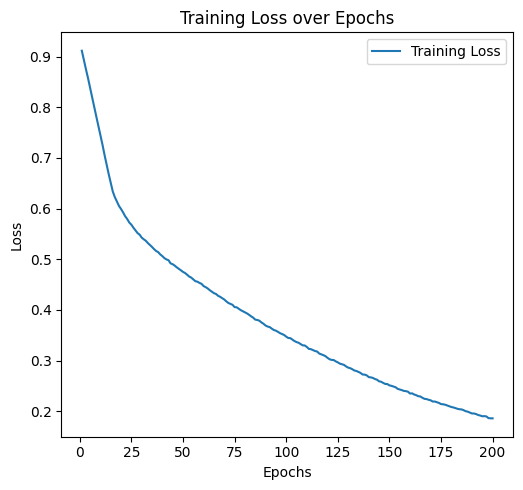

In [398]:
plot_curves({"train" : losses})

In [401]:
import matplotlib.pyplot as plt
def plot_curves2(curves):
    epochs = range(1, len(curves["mrrs"]) + 1)

    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, curves["mrrs"], label='Valid. MRR')
    plt.plot(epochs, curves["mrrs_lr"], label='Valid. MRR (lower lr)')
    plt.plot(epochs, curves["mrrs_marg"], label='Valid. MRR (lower margin)')
    plt.title('Validation MRR over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MRR')
    # plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

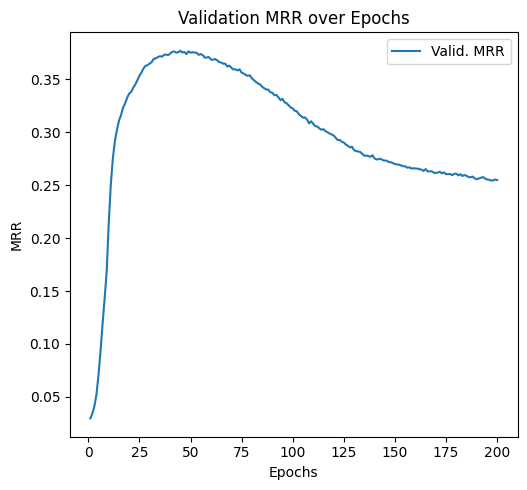

In [402]:
plot_curves2({"mrrs" : mrrs})